In [ ]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Import cuML equivalents for GPU acceleration
from cuml.ensemble import RandomForestRegressor as cuMLRandomForestRegressor
from cuml.model_selection import GridSearchCV as cuMLGridSearchCV

# --- 1. Data Download and Loading ---

# Define the root URL for data download
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# Define the local path where the dataset will be stored
HOUSING_PATH = os.path.join("datasets", "housing")
# Define the full URL to the housing dataset tar.gz file
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Fetches the housing dataset from a URL, extracts it, and saves it locally.
    Args:
        housing_url (str): The URL to the housing.tgz file.
        housing_path (str): The local directory to save the data.
    """
    # Create the directory if it doesn't exist
    os.makedirs(housing_path, exist_ok=True)
    # Define the path for the downloaded tar.gz file
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # Download the file from the URL
    urllib.request.urlretrieve(housing_url, tgz_path)
    # Open the downloaded tar.gz file
    housing_tgz = tarfile.open(tgz_path)
    # Extract all contents to the specified path
    housing_tgz.extractall(path=housing_path)
    # Close the tar.gz file
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """
    Loads the housing dataset from the local CSV file into a pandas DataFrame.
    Args:
        housing_path (str): The local directory where the data is stored.
    Returns:
        pd.DataFrame: The loaded housing dataset.
    """
    # Define the path to the housing.csv file
    csv_path = os.path.join(housing_path, "housing.csv")
    # Read the CSV file into a pandas DataFrame
    return pd.read_csv(csv_path)

# Fetch the housing data (downloads and extracts if not present)
fetch_housing_data()
# Load the housing data into a DataFrame
housing = load_housing_data()
# Print the first few rows of the DataFrame
print("--- Original Housing Data ---")
print(housing.head())
print("\n")

# --- 2. Data Exploration and Preparation ---

# Create an income category attribute to ensure stratified sampling
# Bins are defined to categorize median income into 5 groups
# Labels are 1, 2, 3, 4, 5 corresponding to the bins
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Perform Stratified Shuffle Split for creating training and test sets
# This ensures that the income categories are proportionally represented in both sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Create a copy of the training set for data exploration and preparation
housing_new = strat_train_set.copy()

# Plotting geographical data with population and median house value
# 'alpha' makes points transparent for density visualization
# 's' is size of points, proportional to population
# 'c' is color of points, based on median_house_value
# 'cmap' is the colormap ('jet' goes from blue to red)
print("--- Geographical Scatter Plot (Output to Matplotlib Window) ---")
housing_new.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                 s=housing_new["population"]/300, label="population", figsize=(12,7),
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
# plt.show() # Uncomment to display the plot if running locally

# Calculate the correlation matrix for numerical attributes
corr_matrix = housing_new.corr(numeric_only=True)
# Print correlations with 'total_rooms' in descending order
print("\n--- Correlation with Total Rooms ---")
print(corr_matrix["total_rooms"].sort_values(ascending=False))
print("\n")

# Prepare the data for machine learning algorithms
# Separate features (X) from target labels (y)
# Drop 'median_house_value' from the training set to get features
housing_new = strat_train_set.drop("median_house_value", axis=1)
# Store the target labels
housing_labels = strat_train_set["median_house_value"].copy()

# Handle missing numerical values using SimpleImputer
# Strategy 'median' replaces missing values with the median of the column
imputer = SimpleImputer(strategy="median")

# Separate numerical attributes by dropping the 'ocean_proximity' categorical column
housing_num = housing_new.drop("ocean_proximity", axis=1)
# Fit the imputer on the numerical training data
print("--- Imputer Fit Result (Self-Object) ---")
print(imputer.fit(housing_num))

# Transform the numerical data using the fitted imputer
X = imputer.transform(housing_num)
# Convert the transformed numpy array back to a DataFrame, preserving columns and index
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
print("\n--- Imputed and Transformed Numerical Data (Head) ---")
print(housing_tr.head())
print("\n")

# --- 3. Custom Transformer for Feature Engineering ---

# Define column indices for the CombinedAttributesAdder transformer
# These indices depend on the order of columns in your numerical DataFrame (housing_num)
# Assuming the order is: longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Custom transformer to add new combined attributes to the dataset:
    - rooms_per_household
    - population_per_household
    - (optionally) bedrooms_per_room
    """
    def __init__(self, add_bedrooms_per_room=True):
        # Hyperparameter to control whether 'bedrooms_per_room' is added
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        # This transformer does not need to learn any parameters from the data
        return self

    def transform(self, X):
        # Calculate new features based on existing columns
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Concatenate original features with the three new features
            return np.c_[X,
                         rooms_per_household,
                         population_per_household,
                         bedrooms_per_room]
        else:
            # Concatenate original features with only the first two new features
            return np.c_[X,
                         rooms_per_household,
                         population_per_household]

# --- 4. Building the Numerical Processing Pipeline ---

# Create a pipeline for numerical data preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Handle missing values
    ('attribs_adder', CombinedAttributesAdder()),   # Add custom combined attributes
    ('std_scaler', StandardScaler()),              # Scale features to standard normal distribution
])

# Apply the numerical pipeline to the numerical housing data
housing_num_tr = num_pipeline.fit_transform(housing_num)

# Note: 'ocean_proximity' (categorical feature) is not processed by this numerical pipeline.
# For a full pipeline, you would typically use ColumnTransformer to handle both numerical and categorical features.
# For simplicity in this example, only numerical features are prepared.
housing_prepared = housing_num_tr

# --- 5. Model Training and Evaluation (Random Forest Regressor with cuML) ---

# Initialize a cuML Random Forest Regressor model for GPU acceleration
forest_reg = cuMLRandomForestRegressor(random_state=42) # Added random_state for reproducibility
# Train the Random Forest model on the prepared training data
forest_reg.fit(housing_prepared, housing_labels)

# Perform Grid Search Cross-Validation to find the best hyperparameters for RandomForestRegressor
# param_grid defines the hyperparameters and their values to search
param_grid = [
    # First set of hyperparameters to try
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Second set of hyperparameters to try (with bootstrap=False)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

# Initialize cuML GridSearchCV for GPU-accelerated hyperparameter tuning
# estimator: the model to tune (cuMLRandomForestRegressor)
# param_grid: the dictionary of hyperparameters to search
# cv: number of folds for cross-validation
# scoring: metric to optimize (negative mean squared error, as GridSearchCV maximizes)
# return_train_score: whether to include training scores in the results
# n_jobs=-1 will utilize all available GPU resources for cross-validation
grid_search = cuMLGridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1) # Use all available GPU resources for parallelism
# Fit GridSearchCV to the prepared training data and labels
grid_search.fit(housing_prepared, housing_labels)

# Get the best estimator (model with the best hyperparameters) found by GridSearchCV
final_model = grid_search.best_estimator_
print(f"--- Best Hyperparameters found by cuML GridSearchCV: {grid_search.best_params_} ---")

# Evaluate the final model using cross-validation on the training set
# Note: cross_val_score from scikit-learn is used here. For large datasets,
# you might consider manual cross-validation loops with cuML models for full GPU usage.
scores = cross_val_score(final_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
# Convert negative MSE to RMSE
forest_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    """
    Displays the scores, mean, and standard deviation of cross-validation scores.
    """
    print("--- Cross-Validation Scores for Final Model (cuML) ---")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Display the cross-validation scores for the final model
display_scores(forest_rmse_scores)

print("\n" + "-"*50)
print("-" * 50 + "\n")

# --- 6. Final Evaluation on the Test Set ---

# Prepare the test set
# Drop 'median_house_value' from the test set to get features
X_test = strat_test_set.drop("median_house_value", axis=1)
# Drop 'ocean_proximity' as it was not included in the numerical pipeline
X_test = X_test.drop("ocean_proximity", axis=1)
# Store the true target labels for the test set
y_test = strat_test_set["median_house_value"].copy()

# Apply the same numerical pipeline to the test set
# Note: Use `transform` here, not `fit_transform`, as the pipeline was already fitted on the training data.
X_test_prepared = num_pipeline.transform(X_test)

# Make predictions on the prepared test set using the final model
final_predictions = final_model.predict(X_test_prepared)

# Calculate the Mean Squared Error on the test set
final_mse = mean_squared_error(y_test, final_predictions)
# Calculate the Root Mean Squared Error on the test set
final_rmse = np.sqrt(final_mse)
print(f"--- Final RMSE on the Test Set (cuML): {final_rmse:.2f} ---")

# Calculate the 95% confidence interval for the RMSE
confidence = 0.95
# Calculate squared errors for each prediction
squared_errors = (final_predictions - y_test) ** 2
# Calculate the confidence interval for the mean of squared errors, then take sqrt
# This gives an approximate confidence interval for RMSE
range_ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                   loc=squared_errors.mean(),
                                   scale=stats.sem(squared_errors)))
print(f"--- 95% Confidence Interval for RMSE (cuML): {range_ci} ---")


ModuleNotFoundError: No module named 'cuml'

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


C:\Users\Gaurav Gupta\AppData\Local\Temp\ipykernel_23092\4129458029.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


--- Original Housing Data ---
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


--- Geographical Scatter Plot (Output to Ma

c:\programming\newenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\programming\newenv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [14:49:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\programming\newenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To 

KeyboardInterrupt: 

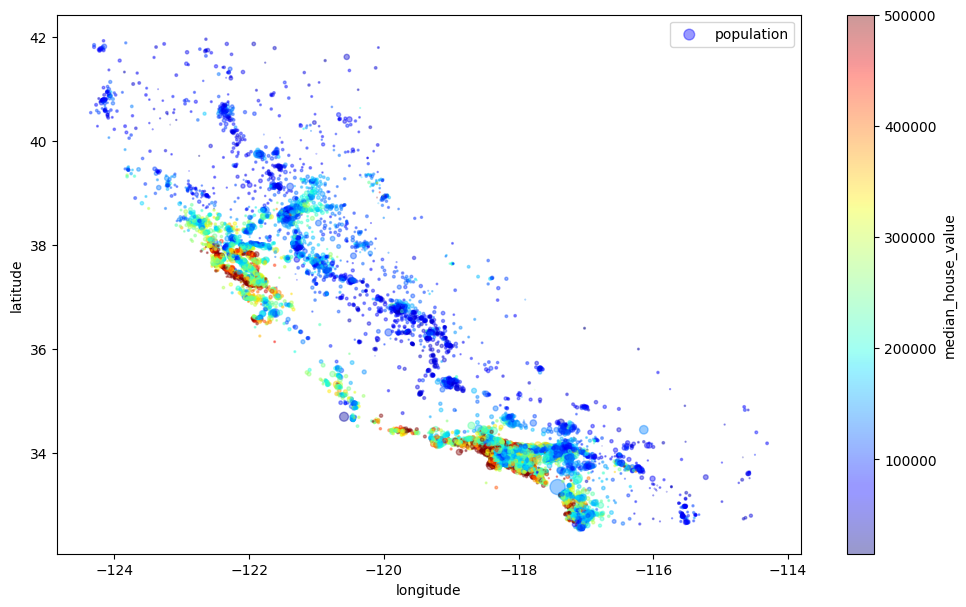

In [3]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
import xgboost as xgb # Import XGBoost

# --- 1. Data Download and Loading ---

# Define the root URL for data download
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# Define the local path where the dataset will be stored
HOUSING_PATH = os.path.join("datasets", "housing")
# Define the full URL to the housing dataset tar.gz file
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Fetches the housing dataset from a URL, extracts it, and saves it locally.
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """
    Loads the housing dataset from the local CSV file into a pandas DataFrame.
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Fetch and load the data
fetch_housing_data()
housing = load_housing_data()
print("--- Original Housing Data ---")
print(housing.head())
print("\n")


# --- 2. Data Exploration and Preparation ---

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing_new = strat_train_set.copy()

print("--- Geographical Scatter Plot (Output to Matplotlib Window) ---")
housing_new.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                 s=housing_new["population"]/300, label="population", figsize=(12,7),
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
# plt.show() # Uncomment to display the plot if running locally

corr_matrix = housing_new.corr(numeric_only=True)
print("\n--- Correlation with Total Rooms ---")
print(corr_matrix["total_rooms"].sort_values(ascending=False))
print("\n")

housing_new = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

imputer = SimpleImputer(strategy="median")
housing_num = housing_new.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


# --- 3. Custom Transformer for Feature Engineering ---

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# --- 4. Building the Numerical Processing Pipeline ---

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_prepared = num_pipeline.fit_transform(housing_num)


# --- 5. Model Training and Evaluation (XGBoost Regressor) ---

# Initialize an XGBoost Regressor for GPU acceleration
# tree_method='gpu_hist' enables GPU usage
xgb_reg = xgb.XGBRegressor(tree_method='gpu_hist', random_state=42, objective='reg:squarederror')

# Define the hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize GridSearchCV (from scikit-learn)
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit GridSearchCV to the data. Each fold will be trained on the GPU.
grid_search.fit(housing_prepared, housing_labels)

# Get the best model found by GridSearchCV
final_model = grid_search.best_estimator_
print(f"--- Best Hyperparameters found by GridSearchCV: {grid_search.best_params_} ---")

# Evaluate the final model using cross-validation
scores = cross_val_score(final_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
xgb_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    """
    Displays the scores, mean, and standard deviation of cross-validation scores.
    """
    print("--- Cross-Validation Scores for Final Model (XGBoost) ---")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(xgb_rmse_scores)

print("\n" + "-"*50)
print("-" * 50 + "\n")


# --- 6. Final Evaluation on the Test Set ---

# Prepare the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
X_test = X_test.drop("ocean_proximity", axis=1) # Drop categorical feature
y_test = strat_test_set["median_house_value"].copy()

# Apply the numerical pipeline to the test set
X_test_prepared = num_pipeline.transform(X_test)

# Make predictions on the prepared test set
final_predictions = final_model.predict(X_test_prepared)

# Calculate the final RMSE on the test set
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"--- Final RMSE on the Test Set (XGBoost): {final_rmse:.2f} ---")

# Calculate the 95% confidence interval for the RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
range_ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                    loc=squared_errors.mean(),
                                    scale=stats.sem(squared_errors)))
print(f"--- 95% Confidence Interval for RMSE (XGBoost): {range_ci} ---")